- Mumford Shah pour la super resolution
- Notebook basé sur la v4 de CMST_...

In [27]:
import sys
sys.path.append('../..')

## CMST_SegMain

In [28]:
import numpy
import lasp.differential
import lasp.utils
import lasp.filters.linear
import lasp.thresholding

import PIL.Image

def decimation(image: numpy.ndarray, d: int) -> numpy.ndarray:
    if d <= 0:
        raise AssertionError('d <= 0')
    return numpy.copy(image[0::d, 0::d])

def mumford_shah(
    img: numpy.ndarray, 
    h: numpy.ndarray, 
    alpha: float,
    beta0: float,
    beta1: float,
    sigma: float,
    d: int,
    nb_iterations: int,
    tolerance: float,
    error_history: list[float] = None
) -> numpy.ndarray:

    bicubic_resized = img
    
    Dx = lasp.differential.dx
    Dy = lasp.differential.dy
    Dxt = lasp.differential.dxT
    Dyt = lasp.differential.dyT

    # Build kernel

    laplacian = lasp.filters.linear.laplacian()
    lap_diag = lasp.utils.fourier_diagonalization(
        kernel = laplacian,
        shape_out = img.shape 
    )
   
    h_diag = lasp.utils.fourier_diagonalization(
        kernel = h,
        shape_out = img.shape
    )

    h2_diag = numpy.abs(h_diag)**2


    # uker = alpha * h2_diag + (beta+sigma) * lap_diag
    # uker = alpha * h2_diag + (1+sigma) * lap_diag

    uker = (1/d) * alpha * h2_diag + (2*beta0+sigma) * lap_diag


    # print('Bicubic Resized : \t {}'.format(bicubic_resized.shape))
    # print('H Diag : \t {}'.format(h_diag.shape))
    # rhs1fft = alpha * numpy.conj(h_diag) * numpy.fft.fft2(img)
    rhs1fft = alpha * h_diag * numpy.fft.fft2(bicubic_resized)

    # Initialization
    u = numpy.copy(img) 
    d_x=numpy.zeros_like(img)
    d_y=numpy.zeros_like(img)
    b_x=numpy.zeros_like(img)
    b_y=numpy.zeros_like(img)

    for _ in range(0, nb_iterations):

        rhs2 = sigma*Dxt(d_x-b_x)+sigma*Dyt(d_y-b_y)
        rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

        u0=numpy.copy(u)
        
        u = numpy.real(numpy.fft.ifft2(rhsfft / uker))    

        err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')
        
        if not(error_history is None):
            error_history.append(err)

        if err < tolerance:
            break
        
        # d_x, d_y = lasp.thresholding.multidimensional_soft(
        #     d = numpy.array([ Dx(u)+b_x, Dy(u)+b_y ]),
        #     epsilon = 1/sigma
        # )

        d_x, d_y = lasp.thresholding.multidimensional_soft(
            d = numpy.array([ Dx(u)+b_x, Dy(u)+b_y ]),
            epsilon = beta1/sigma
        )

        b_x=b_x+Dx(u)-d_x
        b_y=b_y+Dy(u)-d_y

    u_normalized = lasp.utils.normalize(u)

    return u_normalized

In [29]:
import lasp.filters.linear
import lasp.noise
import lasp.io


import pathlib

import numpy

import scipy.signal
import scipy.io

import matplotlib.pyplot

img_original = numpy.array(
    matplotlib.pyplot.imread('Boats.bmp'),
    dtype=numpy.double
)

h = lasp.filters.linear.gaussian_filter(size=7, sigma=3)

img_blurred = numpy.array(
    scipy.signal.convolve2d(img_original, h, mode='same'),
    dtype=numpy.double
)

img_decim = decimation(img_blurred, d=2)
 
img_decim_resized = numpy.array(
    PIL.Image.Image.resize(
        PIL.Image.fromarray(img_blurred), 
        (img_blurred.shape[1], img_blurred.shape[0]), 
        PIL.Image.Resampling.BICUBIC
    )
)

img_noised = lasp.noise.awgn(img_decim_resized, snr=30)
# img_noised = img_blurred


img = numpy.copy(img_noised)
#Img = lasp.noise.awgn(Img_blurred, snr=20)

In [30]:
path = pathlib.Path('outputs')
lasp.io.save(img, path / 'input.png')
lasp.io.save(h, path / 'kernel.png')

# Save img input and kernel as array for matlab
datas_matlab = {}
datas_matlab['input'] = img
datas_matlab['kernel'] = h
scipy.io.savemat(path / 'datas_for_matlab.mat', datas_matlab)

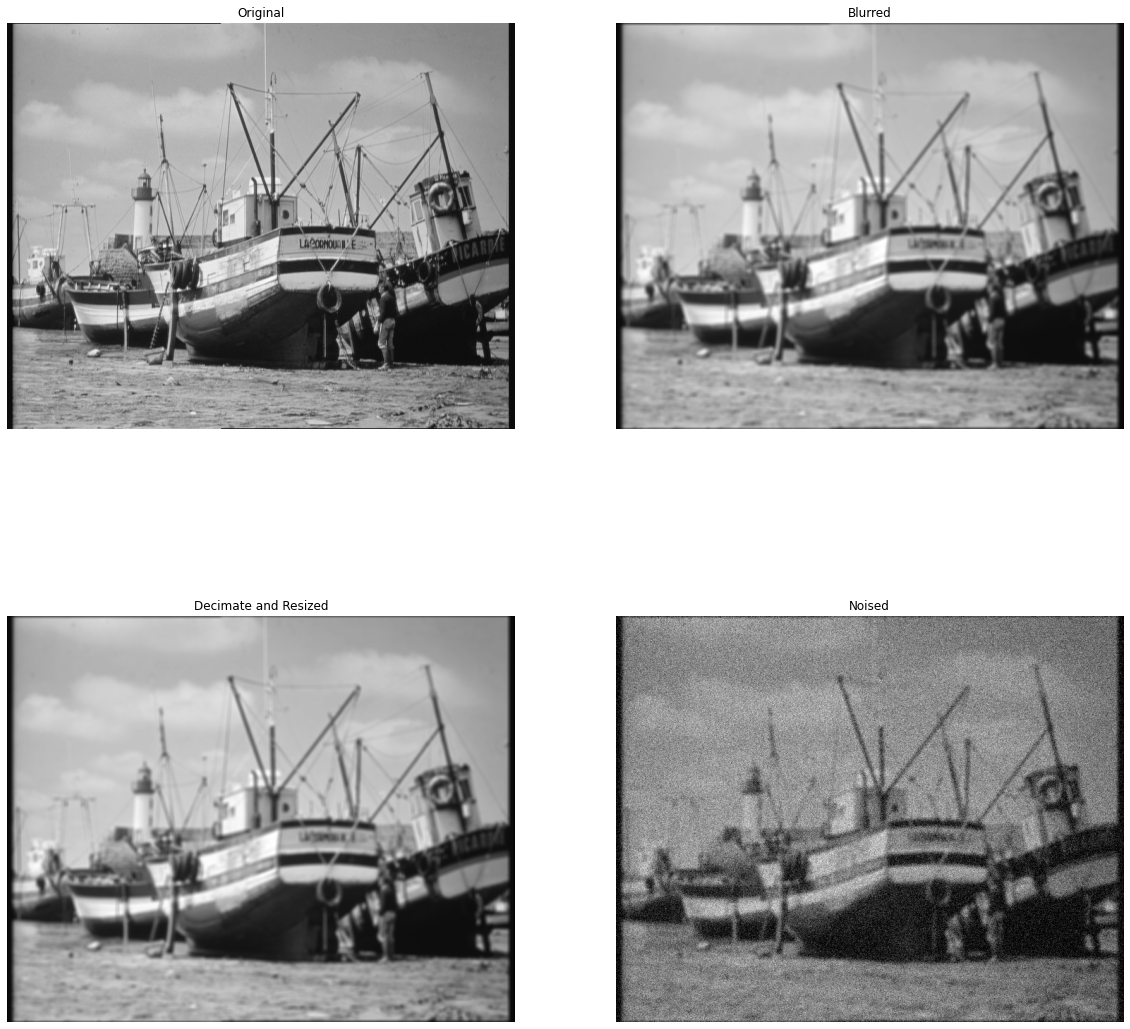

In [31]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Original')
_ = matplotlib.pyplot.imshow(img_original, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Blurred')
_ = matplotlib.pyplot.imshow(img_blurred, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Decimate and Resized')
_ = matplotlib.pyplot.imshow(img_decim_resized, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Noised')
_ = matplotlib.pyplot.imshow(img_noised, cmap='gray')

In [32]:
# img_decim = decimation(Img, 5)
 
# bicubic_resized = numpy.array(
#     PIL.Image.Image.resize(
#         PIL.Image.fromarray(img_decim), 
#         (Img.shape[1], Img.shape[0]), 
#         PIL.Image.Resampling.BICUBIC
#     )
# )
# matplotlib.pyplot.imshow(bicubic_resized, cmap='gray')

In [33]:
import lasp.utils

import numpy
import numpy.linalg


img_normalized = lasp.utils.normalize(img)
errors = []
res = mumford_shah(
    img=img_normalized,
    h=h,
    alpha=100,
    beta0=1/2,
    beta1=1,
    sigma=2,
    d=2,
    nb_iterations=300, 
    tolerance=10**(-6),
    error_history=errors
)

In [34]:
nb_iter = len(errors)
for i in range(0, nb_iter):
    if i%10 == 0:
        print(
            'Iteration {}'.format(i), 
            ':', 
            '\t\t {}'.format(errors[i])
        )
print('Nb iterations : {}'.format(nb_iter))

Iteration 0 : 		 0.7155614827291484
Iteration 10 : 		 0.0020195113970871326
Iteration 20 : 		 0.0005856831654528308
Iteration 30 : 		 0.00027327413767717733
Iteration 40 : 		 0.00015925825388706348
Iteration 50 : 		 0.00010421266827734539
Iteration 60 : 		 7.246192913543055e-05
Iteration 70 : 		 5.2842348203621244e-05
Iteration 80 : 		 4.0889871094727906e-05
Iteration 90 : 		 3.101757209258588e-05
Iteration 100 : 		 2.5956582129143155e-05
Iteration 110 : 		 2.1062456435992534e-05
Iteration 120 : 		 1.7555229469187308e-05
Iteration 130 : 		 1.4591133379771208e-05
Iteration 140 : 		 1.2861544328479263e-05
Iteration 150 : 		 1.1132424816831421e-05
Iteration 160 : 		 9.830483891661687e-06
Iteration 170 : 		 8.103199309442552e-06
Iteration 180 : 		 7.074036896013134e-06
Iteration 190 : 		 6.165676247838619e-06
Iteration 200 : 		 5.719589941214324e-06
Iteration 210 : 		 5.412701155508029e-06
Iteration 220 : 		 5.011228758848753e-06
Iteration 230 : 		 4.522421137667137e-06
Iteration 240 : 		 

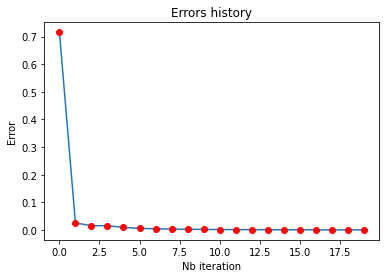

In [35]:
nb_iter = len(errors)
x = numpy.arange(0, nb_iter)
y = errors
matplotlib.pyplot.xlabel(xlabel='Nb iteration')
matplotlib.pyplot.ylabel(ylabel='Error')
matplotlib.pyplot.title('Errors history')
_ = matplotlib.pyplot.plot(x[0:20], y[0:20])
_ = matplotlib.pyplot.plot(x[0:20], y[0:20], 'or')

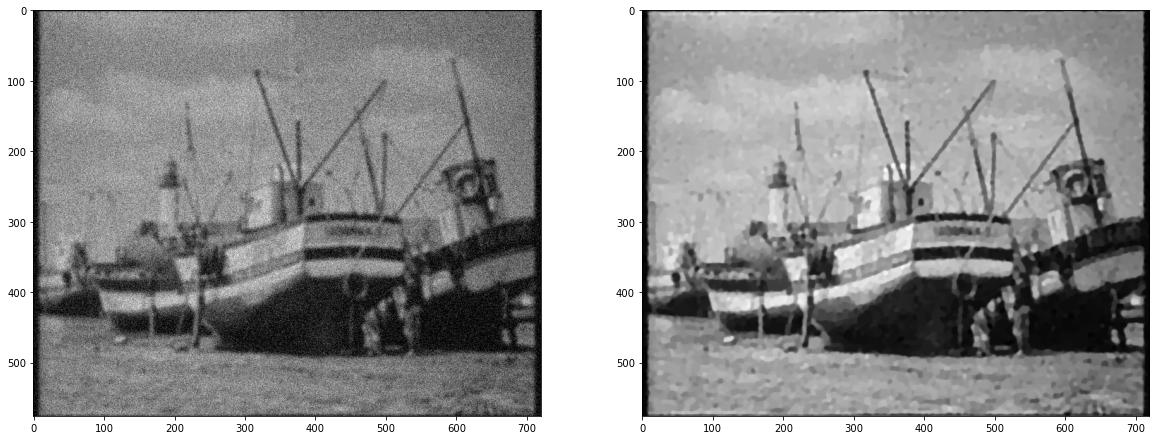

In [36]:
import lasp.io

figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.imshow(numpy.real(res), cmap='gray')

lasp.io.save(res, path / 'output.png')

In [37]:
# import scipy.io.matlab
# import numpy
# a = scipy.io.matlab.loadmat('uu.mat')
# mat_res = numpy.array(numpy.array(a['uu']), dtype=numpy.double) 
# matplotlib.pyplot.imshow(mat_res, cmap='gray')
# print(numpy.max(numpy.abs(mat_res-res)))

In [38]:
# diff = numpy.abs(mat_res-res)
# print(numpy.max(diff))
# diff[1e-6 < diff].shape

In [39]:
# _ = matplotlib.pyplot.imshow(numpy.abs(mat_res-res), cmap='gray')